In [1]:
!pip install langchain
!pip install gpt4all
!pip install chromadb==0.4.7
!pip install llama-cpp-python
!pip install urllib3==2.0.4
!pip install PyMuPDF==1.23.1
!pip install python-dotenv==1.0.0
!pip install tqdm==4.66.1
!pip install sentence_transformers
!pip install langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.5/973.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.5/415.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58

In [1]:
# Standard Library Imports
import os
import glob
import time
from multiprocessing import Pool

# Third-Party Library Imports
from typing import List
from dotenv import load_dotenv
from tqdm import tqdm

# Langchain Imports
from langchain.document_loaders import (
    CSVLoader,
    PyMuPDFLoader,
    TextLoader
)
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA
from langchain.llms import GPT4All, LlamaCpp
from transformers import AutoModel, AutoTokenizer  # Only import required submodules from transformers
import re
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import ast

# ChromaDB Imports
from chromadb.config import Settings
import chromadb

# Argument Parsing
import argparse

import torch  # Import PyTorch to check GPU availability

from google.colab import drive

In [2]:
persist_directory = "./db/"
#model_type = "GPT4All_GPT2"
model_type = "LLaMA_2_7B"
source_directory = "/content/drive/MyDrive/Colab/SOR/"
model_path = "/content/drive/MyDrive/Colab/Models/"
embeddings_model_name = "all-MiniLM-L6-v2"

chunk_size = 500
chunk_overlap = 50
target_source_chunks = 4

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# List files in the specified source directory
archivos = os.listdir(source_directory)

# Count the number of files in the directory
cantidad_de_archivos = len(archivos)

# Print the number of files in the directory
print(f"The folder '{source_directory}' contains {cantidad_de_archivos} files.")


The folder '/content/drive/MyDrive/Colab/SOR/' contains 2 files.


In [5]:
# Check if GPU is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Create embeddings using Hugging Face model
# The 'embeddings_model_name' specifies the pre-trained model to use for embeddings.

# Load the model and tokenizer from transformers, specifying the device
embeddings = HuggingFaceEmbeddings(model_name=embeddings_model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
# Map file extensions to document loaders and their arguments
LOADER_MAPPING = {
    ".csv": (CSVLoader, {}),  # Use the CSVLoader for .csv files with no additional arguments.
    ".txt": (TextLoader, {"encoding": "utf8"}) # Use the TextLoader for .txt files with the specified UTF-8 encoding.
    # Add more mappings for other file extensions and loaders as needed
}


In [8]:
# Function to load a single document based on its file path
def load_single_document(file_path: str) -> List[Document]:
    # Extract the file extension from the given file path.
    ext = "." + file_path.rsplit(".", 1)[-1].lower()

    # Check if the file extension is in the LOADER_MAPPING dictionary.
    if ext in LOADER_MAPPING:
        # Get the loader class and loader arguments for the specified extension.
        loader_class, loader_args = LOADER_MAPPING[ext]

        # Create an instance of the loader class with the specified file path and arguments.
        loader = loader_class(file_path, **loader_args)

        # Load the document using the loader and return it.
        return loader.load()

    # If the file extension is not supported, raise a ValueError.
    raise ValueError(f"Unsupported file extension '{ext}'")

In [9]:
# Function to load documents from the source directory
def load_documents(source_dir: str, ignored_files: List[str] = []) -> List[Document]:
    # Find all files in the source directory with extensions specified in LOADER_MAPPING.
    all_files = []
    for ext in LOADER_MAPPING:
        all_files.extend(
            glob.glob(os.path.join(source_dir, f"**/*{ext.lower()}"), recursive=True)
        )
        all_files.extend(
            glob.glob(os.path.join(source_dir, f"**/*{ext.upper()}"), recursive=True)
        )

    # Filter out files that are in the ignored_files list.
    filtered_files = [file_path for file_path in all_files if file_path not in ignored_files]

    # Use a multiprocessing Pool to load documents in parallel.
    with Pool(processes=os.cpu_count()) as pool:
        results = []
        # Create a progress bar for loading documents.
        with tqdm(total=len(filtered_files), desc='Loading new documents', ncols=80) as pbar:
            for i, docs in enumerate(pool.imap_unordered(load_single_document, filtered_files)):
                results.extend(docs)
                pbar.update()

    return results



In [10]:
# Function to process documents into text chunks
def process_documents(ignored_files: List[str] = []) -> List[Document]:
    # Print a message indicating that documents are being loaded from the specified source directory.
    print(f"Loading documents from {source_directory}")

    # Load documents from the source directory, excluding any ignored files.
    documents = load_documents(source_directory, ignored_files)

    # Check if there are no documents to process and exit if that's the case.
    if not documents:
        print("No new documents to load")
        exit(0)

    # Print the number of loaded documents and the source directory.
    print(f"Loaded {len(documents)} new documents from {source_directory}")

    # Create a text splitter with the specified chunk size and overlap.
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)

    # Split the loaded documents into chunks of text using the text splitter.
    texts = text_splitter.split_documents(documents)

    # Print the number of text chunks created and the maximum chunk size.
    print(f"Split into {len(texts)} chunks of text (max. {chunk_size} tokens each)")

    # Return the resulting text chunks.
    return texts

In [11]:
# Function to check if the vector store already exists
def does_vectorstore_exist(persist_directory: str, embeddings: HuggingFaceEmbeddings) -> bool:
    # Create a Chroma vector store instance with the specified persist directory and embeddings.
    db = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

    # Get the 'documents' data from the vector store. If it's empty, return False; otherwise, return True.
    if not db.get()['documents']:
        return False
    return True

In [12]:
# Check if the vector store already exists in the specified directory with the given embeddings.
if does_vectorstore_exist(persist_directory, embeddings):
    # If the vector store exists, append to it.
    print(f"Appending to existing vector store at {persist_directory}")

    # Create a Chroma vector store instance with the specified directory and embeddings.
    db = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

    # Get the existing collection from the vector store.
    collection = db.get()

    # Extract source file paths from the collection's metadata.
    source_file_paths = [metadata['source'] for metadata in collection['metadatas']]

    # Process the documents based on the extracted source file paths.
    texts = process_documents(source_file_paths)

    # Inform the user about the embeddings creation process.
    print(f"Creating embeddings. May take some minutes...")

       # Check if 'texts' is not empty before adding documents to the vector store
    if texts:
        # Add the processed documents to the vector store.
        db.add_documents(texts)
    else:
        print("No documents to add. Skipping insertion.")
else:
    # If the vector store does not exist, create a new one.
    print("Creating a new vector store")

    # Process documents without specifying ignored files (default behavior).
    texts = process_documents()

    # Inform the user about the embeddings creation process.
    print(f"Creating embeddings. May take some minutes...")

    # Create a new Chroma vector store with the processed documents and embeddings.
    db = Chroma.from_documents(texts, embeddings, persist_directory=persist_directory)

# Persist the vector store.
db.persist()

# Clear the db variable to free up resources.
db = None

# Inform the user that the ingestion process is complete.
print(f"Ingestion complete! You can now run privateGPT.py to query your documents")


Appending to existing vector store at ./db/
Loading documents from /content/drive/MyDrive/Colab/SOR/


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Loading new documents: 0it [00:00, ?it/s]


No new documents to load
Loaded 0 new documents from /content/drive/MyDrive/Colab/SOR/
Split into 0 chunks of text (max. 500 tokens each)
Creating embeddings. May take some minutes...
No documents to add. Skipping insertion.
Ingestion complete! You can now run privateGPT.py to query your documents


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


In [13]:
# Create settings for Chroma database configuration
settings = Settings(
    persist_directory=persist_directory,  # Directory for persisting database data
    anonymized_telemetry=False  # Disable anonymized telemetry
)

# Create Hugging Face embeddings model
embeddings = HuggingFaceEmbeddings(model_name=embeddings_model_name)

# Create a persistent Chroma database client
chroma_client = chromadb.PersistentClient(
    settings=settings,  # Database settings
    path=persist_directory  # Path to the database directory
)

# Create a Chroma vector store instance
db = Chroma(
    persist_directory=persist_directory,  # Directory for persisting vector store data
    embedding_function=embeddings,  # Embeddings function
    client_settings=settings,  # Database settings
    client=chroma_client  # Chroma client
)

# Create a retriever for document retrieval
retriever = db.as_retriever(
    search_kwargs={"k": target_source_chunks}  # Search settings (e.g., number of search results)
)


In [14]:
# Initialize an empty list to store callback handlers (you can add handlers here if needed)
callbacks = []
model_n_batch = 8
model_n_ctx = 1000

# Prepare the Language Model (LLM) based on the specified model_type
match model_type:
    case "LLaMA_2_7B":
        # Create an instance of LlamaCpp
        llm = LlamaCpp(
            model_path =  model_path +"openorca-platypus2-13b.Q4_0.gguf",  # Path to the LlamaCpp model
            max_tokens=model_n_ctx,  # Maximum number of tokens in generated text
            n_batch=model_n_batch,  # Batch size for text generation
            n_threads=8,           # Number of threads to use
            temperature=.8,       # Sampling temperature
            callbacks=callbacks,   # List of callback handlers
            verbose=False          # Set to True for verbose output
        )
    case "GPT4All_GPT2":
        # Create an instance of GPT4All
        llm = GPT4All(
            model = model_path +"GPT4All-13B-snoozy.ggmlv3.q4_0.bin",# Path to the GPT4All model Snoozy
            max_tokens=model_n_ctx, # Maximum number of tokens in generated text
            n_batch=model_n_batch,  # Batch size for text generation
            callbacks=callbacks,    # List of callback handlers
            verbose=False           # Set to True for verbose output
        )

    case _default:
        # Raise an exception if the model_type is not supported
        raise Exception(f"Model type {model_type} is not supported. Please choose one of the following: LlamaCpp, GPT4All")

In [15]:
# Set 'hide_source' to True or False as needed
hide_source = True  # Set to True to hide source documents, False to show them

# Set 'mute_stream' to True or False as needed
mute_stream = True  # Set to True to mute stream output, False to allow it


In [16]:
prompts = [
    "How many Super Bowls have won Tom Brady?",
    "How many ESCAPE NA FHEV sold the dealer Tula on 202403?",
    "How many ETRANSIT V363 sold the dealer Vehiculos De Teziutlan on 202402?",
    "How many vehicles sold the dealer Zapata (Suc. Aeropuerto) in total on 202404?",
    "How many Territory sold the dealer Vista Hermosa Laredo Motors on 202401?"
]
expected_answers = [
    "Tom Brady has won 7 Super Bowls",
    "The dealer Tula sold 4 ESCAPE NA FHEVs on 202403",
    "The dealer Vehiculos De Teziutlan sold 14 Transit V363 trucks in period 202402",
    "82",
    "The dealer Vista Hermosa Laredo Motors sold 2 Territory Vehicles on period 202401"
]

In [17]:
results = {
        "prompts": prompts,
        "expected_answers": expected_answers,
        "model_answers": [],
        "times": [],
        "accuracies": [],
        "precisions": [],
        "recalls": [],
        "f1_scores": []
    }

answers = []
times = []

# Process the prompts
for i, query in enumerate(prompts):
    # Get the answer from the question-answering system
    start = time.time()  # Record the start time for performance measurement

    print(f"\n> Promt: {query}:")  # Print the query
    print(f"\n> Expected Answer: {expected_answers[i]}")  # Print the expected answer
    # Create a RetrievalQA instance for question-answering
    qa_chain = RetrievalQA.from_chain_type(llm, retriever=retriever,return_source_documents = False)

    res = qa_chain(query)  # Query the question-answering system using the user's query
    answer, docs = res['result'], [] if hide_source else res['source_documents']  # Extract answer and source documents
    end = time.time()  # Record the end time for performance measurement

    # Use regex to extract the first sentence from the result
    first_sentence = re.split(r'\.\s', answer, 1)[0].strip()

    # Output the result
    print(f"\n> Model Answer: {first_sentence}") # Print the model's answer and query response time

    # Store the result
    model_answer = answer.strip()
    expected_answer = expected_answers[i].strip()

    results["model_answers"].append(model_answer)
    results["times"].append(round(end - start, 2))

    answers.append(answer)
    times.append(round(end - start, 2))

    # Calculate Metrics
    accuracy = accuracy_score([expected_answer], [model_answer])
    precision = precision_score([expected_answer], [model_answer], average='micro')
    recall = recall_score([expected_answer], [model_answer], average='micro')
    f1 = f1_score([expected_answer], [model_answer], average='micro')

    results["accuracies"].append(accuracy)
    results["precisions"].append(precision)
    results["recalls"].append(recall)
    results["f1_scores"].append(f1)

    # Print the result
    print(f"\n> Model precisions: {precision}") # Print the model's answer and query response time
    print(f"\n> Model accuracies: {accuracy}") # Print the model's answer and query response time
    print(f"\n> Model recalls: {recall}") # Print the model's answer and query response time
    print(f"\n> Model f1_scores: {f1}") # Print the model's answer and query response time
    print(f"\n> Model Answer (took {times[-1]} s):")  # Print the model's answer and query response time

    # Print the relevant sources used for the answer, if not hiding sources
    if not hide_source:
        for document in docs:
            print("\n> " + document.metadata["source"] + ":")  # Print the source document's metadata
            print(document.page_content)  # Print the content of the source document

# Calculate and display the model's performance
average_time = sum(times) / len(times)
print(f"\n\nModel Performance:")
print(f"Average Response Time: {average_time} s")

# Compare model answers with expected answers and calculate accuracy score
correct_answers = 0
for i, answer in enumerate(answers):
    if str(expected_answers[i]).lower() in str(answer).lower():
        correct_answers += 1

accuracy_score = (correct_answers / len(expected_answers)) * 10
print(f"Accuracy Score: {accuracy_score} / 10")


> Promt: How many Super Bowls have won Tom Brady?:

> Expected Answer: Tom Brady has won 7 Super Bowls


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(



> Model Answer: Tom Brady has won 7 Super Bowls

> Model precisions: 0.0

> Model accuracies: 0.0

> Model recalls: 0.0

> Model f1_scores: 0.0

> Model Answer (took 109.17 s):

> Promt: How many ESCAPE NA FHEV sold the dealer Tula on 202403?:

> Expected Answer: The dealer Tula sold 4 ESCAPE NA FHEVs on 202403

> Model Answer: The dealer Tula sold 4 ESCAPE NA FHEV vehicles on 202403.

> Model precisions: 0.0

> Model accuracies: 0.0

> Model recalls: 0.0

> Model f1_scores: 0.0

> Model Answer (took 51.4 s):

> Promt: How many ETRANSIT V363 sold the dealer Vehiculos De Teziutlan on 202402?:

> Expected Answer: The dealer Vehiculos De Teziutlan sold 14 Transit V363 trucks in period 202402

> Model Answer: The information provided does not specify how many ESCAPE NA FHEV (not ETRANSIT V363) were sold in 202402, so we cannot provide an answer for that

> Model precisions: 0.0

> Model accuracies: 0.0

> Model recalls: 0.0

> Model f1_scores: 0.0

> Model Answer (took 99.08 s):

> Promt:

Results saved to LLaMA_2_7B_evaluation_results.csv


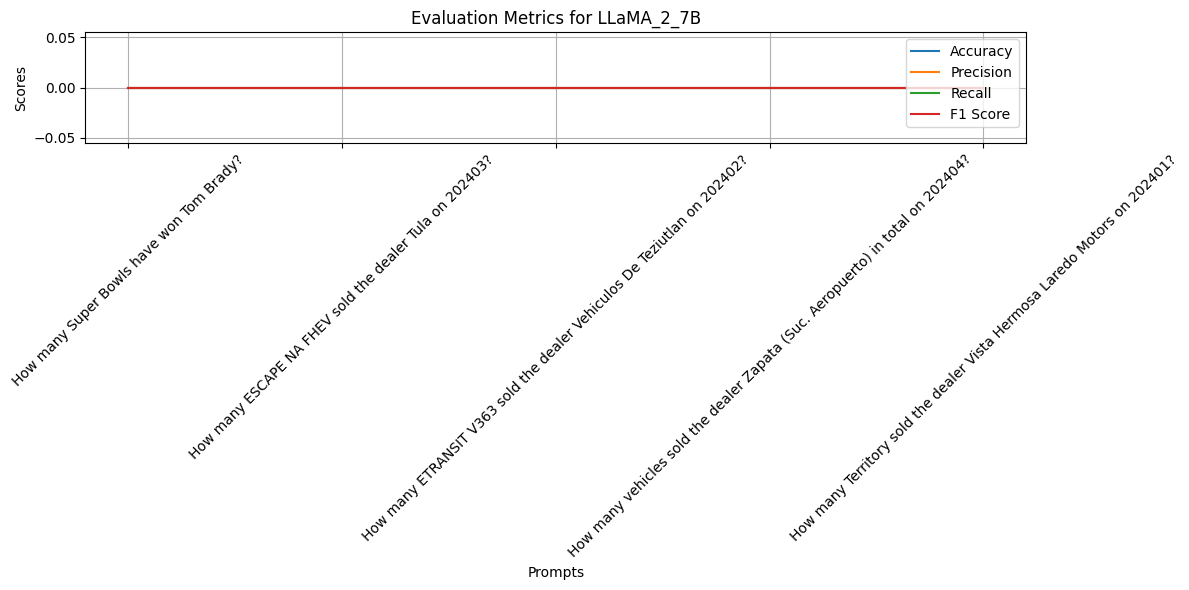

In [18]:
df = pd.DataFrame(results)
df.to_csv(f"{model_type}_evaluation_results.csv", index=False)
print(f"Results saved to {model_type}_evaluation_results.csv")

    # Visualization
plt.figure(figsize=(12, 6))
plt.plot(results["prompts"], results["accuracies"], label="Accuracy")
plt.plot(results["prompts"], results["precisions"], label="Precision")
plt.plot(results["prompts"], results["recalls"], label="Recall")
plt.plot(results["prompts"], results["f1_scores"], label="F1 Score")
plt.xlabel("Prompts")
plt.ylabel("Scores")
plt.title(f"Evaluation Metrics for {model_type}")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{model_type}_evaluation_metrics.png")
plt.show()